# Packages and lib imports

In [30]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# imports

from src.deep.model_analyzer_src import ModelAnalyzer
from src.deep.models import *
from src.deep.trainers import Trainer
from src.general_methods.visualizer import Visualizer
from src.optics.config_manager import ConfigManager

from tqdm.notebook import tqdm
import os


# Parameters configuration

In [32]:
model_name = 'unet_v5_depth6_noiseless_b1_mu043_noreg_v1'
trained_model_path = '/data/yarcoh/thesis_data/data/test_models/'+model_name
main_ds_path = '/data/yarcoh/thesis_data/data/datasets/b1/noiseless/1000samples_20mu'
ds_subdir = 'mu=0.19'
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/100000samples_20mu/'
# ds_subdir = '100000_samples_mu=0.200'
datasetpath = os.path.join(main_ds_path, ds_subdir)

# Init

In [33]:
# load trainer from file
trainer: Trainer = Trainer.load3(trained_model_path)

In [34]:
conf = trainer.train_dataset.config
conf.__dict__


{'W': 0.05,
 'Nspans': 12,
 'La': 80,
 'M_QAM': 16,
 'Ts': 1.0,
 'Nos': 16,
 'eta': 2,
 'mu': 0.43157894736842106,
 'bet': 0.2,
 'with_ssf': True,
 'with_noise': False,
 'beta2': -21.0,
 'gamma': 1.27,
 'dz': 0.2,
 'K_T': 1.13,
 'chi': 0.0461,
 'verbose': False,
 'io_type': 'b1',
 'N_sc': 256,
 'T_guardband': 4750.0880922277665,
 'N_sc_raw': 237.50440461138834,
 'L': 960,
 'T0': 5120.0,
 'Tb': 10240.0,
 'Tn': 1358.1221810508403,
 'Zn': 87833.13612677579,
 'Pn': 8.964743939765935e-06,
 'Ns': 4096,
 'Nnft': 16384,
 'Tnft': 68266.66666666667,
 'dt': 4.166666666666667,
 'Nb': 2458,
 'T1': -25.132741228718345,
 'T2': 25.12967326714258,
 'XI': array([-511.9375,  512.    ])}

In [35]:
trainer.print_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 4, 4096]              28
              Tanh-2              [-1, 4, 4096]               0
         MaxPool1d-3              [-1, 4, 2048]               0
            Conv1d-4              [-1, 8, 2048]             104
              Tanh-5              [-1, 8, 2048]               0
         MaxPool1d-6              [-1, 8, 1024]               0
            Conv1d-7             [-1, 16, 1024]             400
              Tanh-8             [-1, 16, 1024]               0
         MaxPool1d-9              [-1, 16, 512]               0
           Conv1d-10              [-1, 32, 512]           1,568
             Tanh-11              [-1, 32, 512]               0
        MaxPool1d-12              [-1, 32, 256]               0
           Conv1d-13              [-1, 64, 256]           6,208
             Tanh-14              [-1, 

saved model architecture to /data/yarcoh/thesis_data/data/test_models/unet_v5_depth6_noiseless_b1_mu043_noreg_v1/_analyze/architecture.png


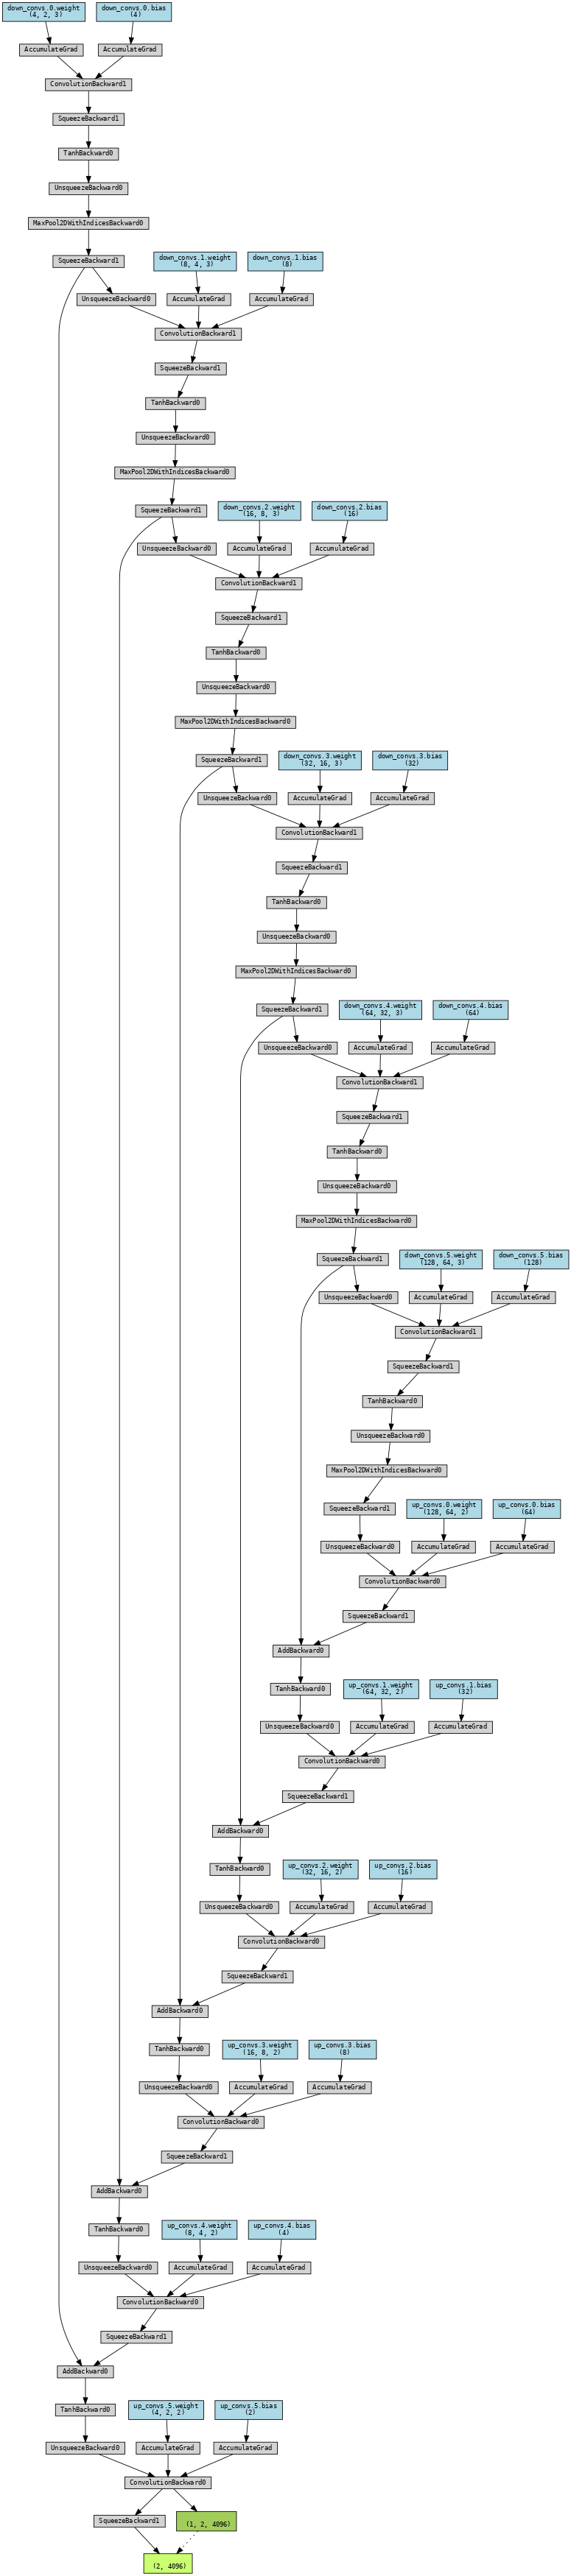

In [36]:
from IPython.display import Image
path = f'{trained_model_path}/_analyze/architecture'
trainer.plot_architecture(path)

# Replace 'image_path' with the path to your image file
Image(filename=path+'.png')


In [37]:
# for broken models with old config

# inp = input('Do you want to refresh config? (y/n) ')
# if inp == 'y':
#     trainer.train_dataset.config = ConfigManager.refresh_config(trainer.train_dataset.config)
#     trainer.save(trained_model_path)
# else:
#         print('config not refreshed')

In [38]:
ma: ModelAnalyzer = ModelAnalyzer(trainer,model_name)

In [39]:
ma.load_test_dataset(datasetpath, train_ds_ratio=0.4, val_ds_ratio=0.3, test_ds_ratio=0.3)

In [40]:
print(len(trainer.val_dataset))

300


In [41]:
#pretty print ds config


# Visualizer.print_config(trainer.val_dataset.config)

# analyze 1 sample

In [42]:
print(ma.cs_in.channel_config.io_type)

b1


In [43]:
# ma.plot_single_item(1)
# N = ma.cs_in.channel_config.Ns
# N = ma.cs_in.channel_config.N_sc
# ma.cs_in.channel_config.io_type
# ma.plot_single_item_together(i=1, zm_indices=range(N//2,N//2+50))

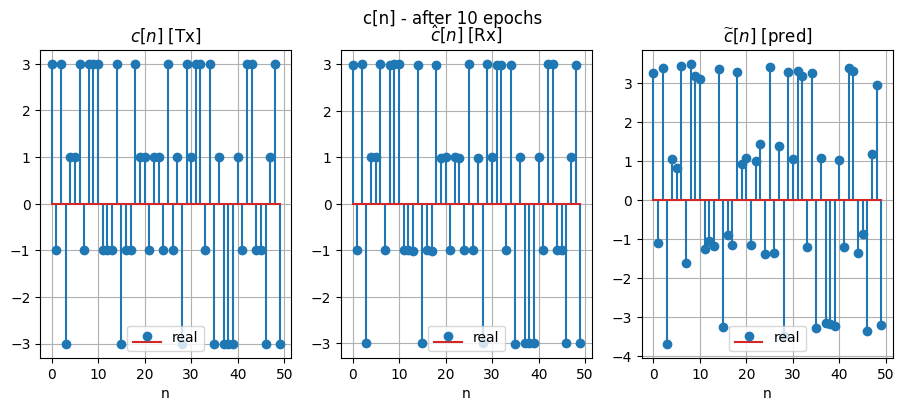

In [44]:
ma.plot_stems(i=1, zm_indices=range(0,50))

# analyze constelation

  0%|          | 0/40 [00:00<?, ?it/s]

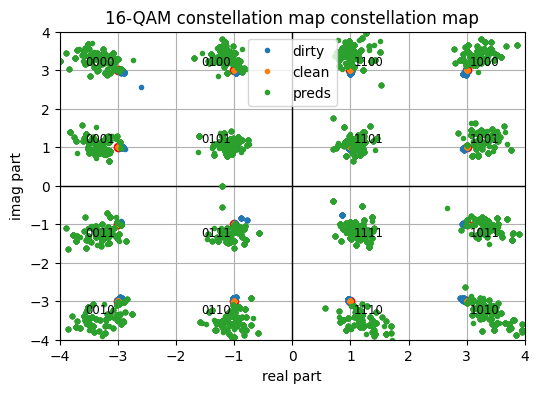

In [45]:
ma.plot_constelation(range(0,40))

In [46]:
# x_power_i, y_power, pred_power = ma.calc_norms(_tqdm=tqdm, verbose_level=1, max_items=10000)
# print(f'x_power: {x_power_i}\ny_power: {y_power}\npred_power: {pred_power}')

In [47]:
# ma.upload_single_item_plots_to_wandb(1)

In [48]:
ma.plot_bers(_tqdm=tqdm, verbose_level=1,num_x_per_folder=1000)

  0%|          | 0/300 [00:00<?, ?it/s]

the original avg ber (of validation set) is 0.0


  0%|          | 0/300 [00:00<?, ?it/s]

the trained avg ber (of validation set) is 7.8125e-05
the ber improvement is 0.00%


In [49]:
ma.upload_bers_to_wandb()

the original avg ber (of validation set) is 0.0
the trained avg ber (of validation set) is 7.8125e-05
the ber improvement is 0.00%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


ber_improvement,███████▄▁▁▂▅▆▇▇██████
model_ber,▁▁▁▁▁▁▁▁▂▃▄▅▆▆▆▇▇▇███
mu,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
org_ber,▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▆▇▇███
ber_improvement,-0.0036
model_ber,0.35591
mu,1.0
org_ber,0.35464


# test all BERs

In [50]:
# add powers

# from apps.deep.power_adder import PowerAdder


# power_adder = PowerAdder(is_overright=True, verbose_level=2)
# power_adder.calculate_and_add_powers(main_ds_path)
# power_adder.replace_key_in_config_files(main_ds_path)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.100 | org_ber=0.00e+00 | model_ber=1.03e-03 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.150 | org_ber=0.00e+00 | model_ber=6.25e-05 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.190 | org_ber=0.00e+00 | model_ber=9.18e-05 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.240 | org_ber=0.00e+00 | model_ber=3.32e-05 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.290 | org_ber=0.00e+00 | model_ber=2.81e-04 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.340 | org_ber=0.00e+00 | model_ber=6.16e-03 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.380 | org_ber=2.24e-03 | model_ber=5.39e-02 |  ber_improve=-2300%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.430 | org_ber=1.06e-02 | model_ber=5.98e-02 |  ber_improve=-466%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.480 | org_ber=3.46e-02 | model_ber=1.81e-01 |  ber_improve=-425%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.530 | org_ber=6.93e-02 | model_ber=2.25e-01 |  ber_improve=-225%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.570 | org_ber=1.19e-01 | model_ber=2.40e-01 |  ber_improve=-102%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.620 | org_ber=1.71e-01 | model_ber=2.60e-01 |  ber_improve=-52%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.670 | org_ber=2.14e-01 | model_ber=2.72e-01 |  ber_improve=-27%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.720 | org_ber=2.41e-01 | model_ber=2.80e-01 |  ber_improve=-16%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.760 | org_ber=2.74e-01 | model_ber=2.98e-01 |  ber_improve=-09%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.810 | org_ber=3.02e-01 | model_ber=3.16e-01 |  ber_improve=-05%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.860 | org_ber=3.21e-01 | model_ber=3.28e-01 |  ber_improve=-02%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.910 | org_ber=3.36e-01 | model_ber=3.39e-01 |  ber_improve=-01%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.950 | org_ber=3.53e-01 | model_ber=3.55e-01 |  ber_improve=-01%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=1.000 | org_ber=3.55e-01 | model_ber=3.57e-01 |  ber_improve=-01%


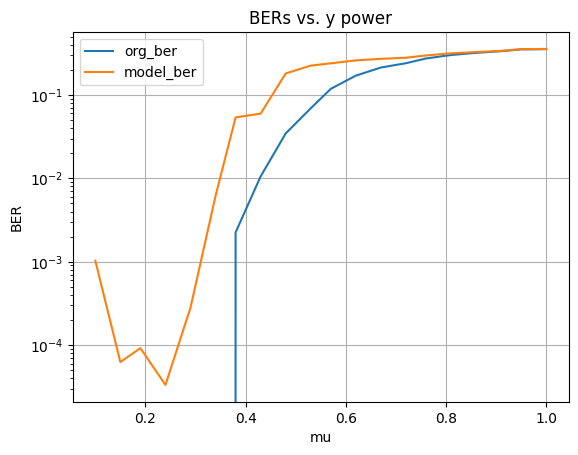

In [51]:
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/qam16_50x300/'

ma.plot_all_bers(base_path=main_ds_path, 
                 train_ds_ratio=0, 
                 val_ds_ratio=0, 
                 test_ds_ratio=0.5, 
                 _tqdm=tqdm, 
                 verbose_level=0.5)
                    

In [52]:
# upload to wandb
ma.upload_all_bers_to_wandb(base_path=main_ds_path,
                 train_ds_ratio=0, 
                 val_ds_ratio=0, 
                 test_ds_ratio=0.5, 
                 _tqdm=tqdm, 
                 verbose_level=0.5)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.1 ----------------
org_ber=0.0, model_ber=0.00102734375, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.15 ----------------
org_ber=0.0, model_ber=6.25e-05, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.19 ----------------
org_ber=0.0, model_ber=9.1796875e-05, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.24 ----------------
org_ber=0.0, model_ber=3.3203125e-05, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.29 ----------------
org_ber=0.0, model_ber=0.00028125, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.34 ----------------
org_ber=0.0, model_ber=0.006162109375, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.38 ----------------
org_ber=0.002244140625, model_ber=0.053869140625, ber_improvement=-23.004351610095735




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.43 ----------------
org_ber=0.01055859375, model_ber=0.059783203125, ber_improvement=-4.662042175360711




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.48 ----------------
org_ber=0.03458203125, model_ber=0.181408203125, ber_improvement=-4.245735908731503




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.53 ----------------
org_ber=0.06926953125, model_ber=0.22520703125, ber_improvement=-2.2511701347769697




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.57 ----------------
org_ber=0.1185625, model_ber=0.2399765625, ber_improvement=-1.0240511333684765




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.62 ----------------
org_ber=0.170791015625, model_ber=0.260134765625, ber_improvement=-0.5231173880725027




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.67 ----------------
org_ber=0.213701171875, model_ber=0.2716484375, ber_improvement=-0.2711602613901201




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.72 ----------------
org_ber=0.240634765625, model_ber=0.28015234375, ber_improvement=-0.16422223124061516




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.76 ----------------
org_ber=0.27438671875, model_ber=0.29834765625, ber_improvement=-0.0873254274447276




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.81 ----------------
org_ber=0.301916015625, model_ber=0.316359375, ber_improvement=-0.04783899703068301




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.86 ----------------
org_ber=0.320705078125, model_ber=0.32765234375, ber_improvement=-0.021662474649971782




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.91 ----------------
org_ber=0.33551953125, model_ber=0.338724609375, ber_improvement=-0.009552582864726992




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.95 ----------------
org_ber=0.352740234375, model_ber=0.354765625, ber_improvement=-0.005741875827090234




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=1.0 ----------------
org_ber=0.35463671875, model_ber=0.35721484375, ber_improvement=-0.007269763292101254




# THE END

In [53]:
# # paper 1 model analyzer
# path_init = '../../data/test_models/mu-0.008__128ds__PaperNNforNFTmodel__3epochs'

# trainer_real = Trainer.load3(path_init + '__real')
# trainer_imag = Trainer.load3(path_init + '__imag')

# train_ds = SingleMuDataSet(trainer_real.train_dataset.data_dir_path,
#                            trainer_real.train_dataset.data_indices)
# val_ds = SingleMuDataSet(trainer_real.val_dataset.data_dir_path,
#                          trainer_real.val_dataset.data_indices)

# model = PaperNNforNFTwrapper(trainer_real.model, trainer_imag.model)

# trainer = Trainer(
#     train_dataset=train_ds,
#     val_dataset=val_ds,
#     model=model,
#     device=trainer_real.device,
#     batch_size=trainer_real.train_dataloader.batch_size,
#     l_metric=trainer_real.l_metric,
#     optim=trainer_real.optim,
#     params=trainer_real.params)

In [54]:
# analyze on the whole dataset

# attach new dataset to trainer


In [55]:
# trainer.params

In [56]:
# ma = ModelAnalyzer(trainer)

In [ ]:
# ma.plot_single_item(i=0)

In [ ]:
# ma.plot_bers(_tqdm=tqdm)